# Connectivity Classifier

Steps:
1. Load the data
2. Fit a SVM + HPO
3. Permutation testing
4. Permutation Importance
5. SHAP

## Inputs

Connectivity matrices

## Outputs

Participant's label, either AVGP or NVGP.

## Requirements

To run this notebook, you need to have the rapids packages installed:

```bash
mamba create -n rapids-22.04 \
    -c rapidsai -c nvidia -y \
    rapids=22.04 python=3.9 cudatoolkit=11.5 \
    jupyterlab ipykernel nilearn xarray netcdf4 seaborn shap \
    xarray netcdf4

mamba activate rapids-22.04

pip install statannotations -U

# [Optional] Bayesian HBO
# pip install "ray[tune]" tune-sklearn scikit-optimize
```


## Analysis

In [ ]:
# 0. SETUP

%reload_ext autoreload
%autoreload 3

import numpy as np
import pandas as pd
import scipy.stats as st
import xarray as xr
from python.acnets.pipeline import ConnectivityPipeline, ConnectivityVectorizer
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.inspection import permutation_importance
from sklearn.model_selection import (GridSearchCV, StratifiedShuffleSplit,
                                     cross_val_score, learning_curve,
                                     permutation_test_score)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC
from tqdm.auto import tqdm


In [ ]:
# 1. DATA

subjects = ConnectivityPipeline().transform('all').coords['subject'].values
groups = [s[:4] for s in subjects]  # AVGP or NVGP

X = subjects.reshape(-1, 1)

y_encoder = LabelEncoder()
y = y_encoder.fit_transform(groups)

results = xr.Dataset()


In [ ]:
# 2. MODELING PIPELINE

pipe  = Pipeline([
    ('connectivity', ConnectivityPipeline()),
    ('vectorize', ConnectivityVectorizer()),
    ('scale', StandardScaler()),
    ('zerovar', VarianceThreshold()),
    ('select', SelectFromModel(LinearSVC(penalty='l1', dual=False, max_iter=10000))),
    ('clf', LinearSVC(penalty='l1', dual=False, max_iter=10000))
])

# DEBUG
# pipe.fit(X, y).score(X, y)

In [ ]:
# 2.1 VERIFY THE MODEL
pipe.set_params(connectivity__atlas='dosenbach2010', connectivity__kind='partial correlation')

scores = cross_val_score(pipe, X, y,
                         cv=StratifiedShuffleSplit(n_splits=5, test_size=8),
                         scoring='accuracy',
                         n_jobs=-1)
bootstrap_ci = st.bootstrap(scores.reshape(1,-1), np.mean)
scores.mean(), scores.std(), bootstrap_ci

(0.775,
 0.09354143466934853,
 BootstrapResult(confidence_interval=ConfidenceInterval(low=0.65, high=0.825), standard_error=0.04162725475989363))

In [ ]:
# 3. HPO: GRID SEARCH

param_grid = {
    'connectivity__atlas': ['gordon2014_2mm', 'dosenbach2010', 'difumo_64_2mm'],
    # 'connectivity__atlas': ['seitzman2018'],
    'connectivity__kind': ['partial correlation', 'tangent', 'correlation', 'covariance', 'precision'],
}

grid = GridSearchCV(
    pipe,
    param_grid,
    cv=StratifiedShuffleSplit(n_splits=3, test_size=8),
    verbose=1,
    scoring='accuracy')

grid.fit(X, y)

print('best estimator:', grid.best_estimator_)


Fitting 3 folds for each of 15 candidates, totalling 45 fits
best estimator: Pipeline(steps=[('connectivity',
                 ConnectivityPipeline(kind='partial correlation')),
                ('vectorize', ConnectivityVectorizer()),
                ('scale', StandardScaler()), ('zerovar', VarianceThreshold()),
                ('select',
                 SelectFromModel(estimator=LinearSVC(dual=False, max_iter=10000,
                                                     penalty='l1'))),
                ('clf', LinearSVC(dual=False, max_iter=10000, penalty='l1'))])


In [ ]:

#STORE pd.DataFrame(grid.cv_results_).set_index('params')
#STORE grid.scoring, grid.cv.test_size,  grid.cv.n_splits, n_subjects
grid_results = pd.DataFrame(grid.cv_results_)

grid_results['model'] = grid_results['params'].apply(lambda x: ' '.join(x.values()))
grid_results.set_index('model', inplace=True)

grid_seach_results = grid_results.to_xarray()
grid_seach_results['scoring'] = grid.scoring
grid_seach_results['cv_test_size'] = grid.cv.test_size
grid_seach_results['cv_n_splits'] = grid.cv.n_splits
grid_seach_results['n_subjects'] = len(X)


In [ ]:
# PERMUTATION TESTING (SHUFFLE Y)

_, perm_scores, pvalue = permutation_test_score(grid.best_estimator_, X, y,
                                                scoring='accuracy',
                                                n_permutations=3,
                                                cv=4,
                                                n_jobs=-1, verbose=1)

cv_scores = cross_val_score(grid.best_estimator_, X, y,
                            cv=StratifiedShuffleSplit(n_splits=3, test_size=8),
                            scoring='accuracy', n_jobs=-1)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.4s finished


In [ ]:
# STORE perm_scores, pvalue, cv_scores
perm_scores_df = pd.DataFrame(perm_scores, columns=['best_estimator_perm_scores'])
perm_scores_df.index.name = 'permutation'
perm_scores_df = perm_scores_df.to_xarray()

cv_scores_df = pd.DataFrame(cv_scores, columns=['best_estimator_cv_scores'])
cv_scores_df.index.name = 'cross_validation'
cv_scores_df = cv_scores_df.to_xarray()

perm_scores_df['perm_pvalue'] = pvalue
perm_scores_df

<xarray.Dataset>
Dimensions:                     (permutation: 3)
Coordinates:
  * permutation                 (permutation) int64 0 1 2
Data variables:
    best_estimator_perm_scores  (permutation) float64 0.375 0.5 0.6562
    perm_pvalue                 float64 0.25

In [ ]:
# FEATURE IMPORTANCE (SHUFFLE X)

cv = StratifiedShuffleSplit(n_splits=3, test_size=8)

model: Pipeline = grid.best_estimator_  # type: ignore

model.set_params(connectivity__kind='tangent')

X_conn = model[:2].transform(X)
feature_names = model[:2].get_feature_names_out()

importances = []

for train, test in tqdm(cv.split(X,y), total=cv.get_n_splits(X,y)):
    model.fit(X[train], y[train])

    results = permutation_importance(model[2:], X_conn[test], y[test],
                                     scoring=grid.scoring,
                                     n_jobs=1)
    importances.append(results.importances.T)


importances = pd.DataFrame(np.vstack(importances), columns=feature_names)


# sort by mean importance
sorted_columns = importances.mean(axis=0).sort_values(ascending=False).index
perm_imp_scores = importances[sorted_columns]


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:

# STORE perm_imp_scores
perm_imp_scores

In [ ]:
# SHAP

import shap
from tqdm.auto import tqdm

shap_values_cv = []
test_indices = []
y_test_cv = []
y_pred_cv = []

feature_names = grid.best_estimator_[:2].get_feature_names_out()

cv = StratifiedShuffleSplit(n_splits=100, test_size=8)

n_splits = cv.get_n_splits(X, y)

X_conn = grid.best_estimator_[:2].fit_transform(X, y)

for train, test in tqdm(cv.split(X, y), total=n_splits):

    shap_model = grid.best_estimator_[2:].fit(X_conn[train], y[train])

    y_pred = shap_model.predict(X_conn[test])

    test_indices.extend(test)
    y_test_cv.append(y[test])
    y_pred_cv.append(y_pred)

    explainer = shap.Explainer(
        shap_model.predict, X_conn[train],
        feature_names=feature_names,
        # approximate=True,
        # model_output='raw',
        # feature_perturbation='interventional',
    )

    shap_values = explainer(X_conn[test])#, check_additivity=True)

    shap_values_cv.append(shap_values)

# merge CV SHAPs

# X = subjects.reshape(-1, 1)
# X_test = pd.DataFrame(X[np.hstack(test_indices)], columns=['subject'])
y_test = np.hstack(y_test_cv)
y_pred = np.hstack(y_pred_cv)


# merge CV SHAPs
shap_values = shap.Explanation(
  values = np.vstack([sh.values for sh in shap_values_cv]),
  base_values = np.hstack([sh.base_values for sh in shap_values_cv]),
  data = np.vstack([sh.data for sh in shap_values_cv]),
  feature_names=feature_names,
  compute_time=np.sum([sh.compute_time for sh in shap_values_cv]),
  output_names=y_encoder.classes_,
  output_indexes=y_pred,
)

# STORE y_pred, y_test, shap_values


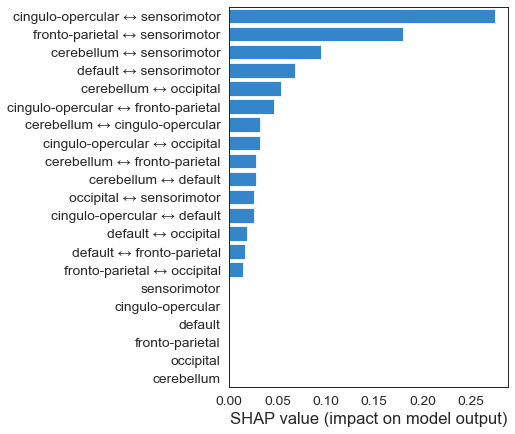

In [157]:
shap_importances = pd.DataFrame({
    'shap': np.abs(shap_values.values).mean(axis=0),
    'feature_name': feature_names
}).sort_values('shap')

shap_importances

## Appendix

In [47]:
# LEARNING CURVE ANALYSIS

train_sizes, train_scores, test_scores = learning_curve(grid.best_estimator_, X, y,
                                                        cv=StratifiedShuffleSplit(n_splits=10, test_size=8),
                                                        scoring='accuracy',
                                                        n_jobs=-1,
                                                        shuffle=True,
                                                        train_sizes=np.array([16, 18, 20, 22, 24]))


learning_curve_results = pd.DataFrame({
    'train_size': train_sizes,
    'mean_train_score': train_scores.mean(axis=1),
    'mean_test_score': test_scores.mean(axis=1)
})

learning_curve_results

# STORE learning_curve_results

,train_size,mean_train_score,mean_test_score
0,16,1.0,0.6000
1,18,1.0,0.6250
2,20,1.0,0.6500
3,22,1.0,0.6875
4,24,1.0,0.6875
